<h1 align="center">Data Science - Final Project</h1>
<h1 align="center">Air Quality</h1>

<h4 align="center">Thành viên nhóm</h4>

|MSSV|Họ và Tên
|:---|:-
|18120212|Huỳnh Long Nam
|18120293|Vòng Cảnh Chi


# Giới thiệu đề tài

Theo UNICEF, thực trạng ô nhiễm môi trường hiện nay khá nóng và đang diễn ra ở khắp nơi trên thế giới, đặc biệt tại các nước đang phát triển, trong đó có Việt Nam. Bên cạnh ô nhiễm môi trường đất, nước do chất thải từ các công ty, xí nghiệp chưa qua xử lý đúng quy trình bị xả thẳng ra môi trường thì chất thải, khói bụi từ hoạt động của các nhà máy sản xuất, khí thải từ các phương tiện giao thông,... đã làm cho chất lượng không khí, đặc biệt tại các thành phố lớn, giảm sút và ô nhiễm đáng kể gây ra ô nhiễm không khí khá trầm trọng. Ô nhiễm không khí làm cho mọi người phải tiếp xúc với các hạt mịn trong không khí bị ô nhiễm. Các hạt mịn này thâm nhập sâu vào phổi và hệ thống tim mạch, gây ra các bệnh đột quỵ, bệnh tim, ung thư phổi, bệnh phổi tắc nghẽn mãn tính và các bệnh nhiễm trùng đường hô hấp, ảnh hưởng tới các nền kinh tế và chất lượng cuộc sống của con người. 

Ô nhiễm không khí đe dọa sức khỏe của người dân ở khắp mọi nơi trên thế giới. Ước tính mới đây năm 2018 cho thấy rằng 9/10 người dân phải hít thở không khí chứa hàm lượng các chất gây ô nhiễm cao. Ô nhiễm không khí cả ở bên ngoài và trong nhà gây ra khoảng 7 triệu ca tử vong hàng năm trên toàn cầu; chỉ tính riêng khu vực Tây Thái Bình Dương, khoảng 2,2 triệu người tử vong mỗi năm. Ở Việt Nam, khoảng 60.000 người chết mỗi năm có liên quan đến ô nhiễm không khí.


Vì vậy nhóm quyết định thu thập dữ liệu về chất lượng không khí ở các thành phố lớn, cụ thể là thành phố Hồ Chí Minh, để có những cái nhìn về chất lượng không khí nơi đó cũng như tại các thành phố lớn trên thế giới.

Dừ liệu được nhóm em thu thập từ https://openweathermap.org

## Import các thư viện cần thiết

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import requests
import json
import pandas as pd
import numpy as np
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score

# Bắt đầu quá trình thu thập dữ liệu

Chúng em sẽ thu thập dữ liệu thông qua api do trang https://openweathermap.org đã cung cấp sẵn và lưu và biến data.
Api: http://api.openweathermap.org/data/2.5/air_pollution/history?lat=10.7546664&lon=106.415029&start=946726894&end=1610129052&appid=9f7c977884b479967cee75682a860b6b

In [2]:
#REST API
'''
    Sử dụng api từ openweathermap.org
    Lấy dữ liệu chất lượng không khí tại TP HCM từ 2000 - 2021 
    Nhận được 1032 bộ dữ liệu ~ 3 năm

'''
data=requests.get('http://api.openweathermap.org/data/2.5/air_pollution/history?lat=10.7546664&lon=106.415029&start=946726894&end=1610129052&appid=9f7c977884b479967cee75682a860b6b')

In [3]:
#Parse JSON
air_quality=json.loads(data.text)

In [4]:
#Test
air_quality['list'][0]

{'main': {'aqi': 2},
 'components': {'co': 460.63,
  'no': 0,
  'no2': 15.08,
  'o3': 25.03,
  'so2': 7.87,
  'pm2_5': 11.18,
  'pm10': 15.02,
  'nh3': 8.74},
 'dt': 1610128800}

In [5]:
#Simplize dicts
def make_flat_dict(p):
    res={};
    components=p['components']
    
    res['dt']=p['dt']
    res['co']=components['co']
    res['no']=components['no']
    res['no2']=components['no2']
    res['o3']=components['o3']
    res['so2']=components['so2']
    res['pm2_5']=components['pm2_5']
    res['pm10']=components['pm10']
    res['nh3']=components['nh3']
    res['aqi']=p['main']['aqi']
    
    return res
    pass

In [6]:
# Make list records
list_records=[]
for record in air_quality['list']:
    list_records.append(make_flat_dict(record))
    

Kích thước dữ liệu thu được

In [7]:
len(list_records)

1074

In [8]:
#Write to csv
with open('air_quality.csv', 'w',newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=list_records[0].keys())
        writer.writeheader()
        for data in list_records:
            writer.writerow(data)

---

# Khám phá dữ liệu (đủ để có thể xác định câu hỏi)

In [9]:
# Đọc dữ liệu từ file đã thu thập trước đó
data_df = pd.read_csv('air_quality.csv')

**Tổng quan về dữ liệu thu được**

In [10]:
data_df.head(10)

,dt,co,no,no2,o3,so2,pm2_5,pm10,nh3,aqi
0,1610128800,460.63,0.00,15.08,25.03,7.87,11.18,15.02,8.74,2
1,1610125200,460.63,0.00,16.62,25.39,7.57,11.64,16.03,9.25,2
2,1610121600,567.44,0.00,27.08,24.68,13.11,16.42,22.47,10.26,2
3,1610118000,821.11,0.00,49.35,21.99,28.13,28.67,39.75,13.17,4
4,1610114400,947.95,0.00,53.47,31.11,32.42,37.76,54.19,15.33,4
5,1610110800,907.90,0.00,43.87,57.22,27.42,43.63,60.96,15.45,4
6,1610107200,867.84,0.00,35.64,104.43,26.70,58.16,73.05,14.57,5
7,1610103600,774.38,0.03,28.45,164.51,26.94,72.66,84.56,11.40,5
8,1610100000,660.90,0.22,17.31,214.58,25.51,79.09,88.34,7.35,5
9,1610096400,640.87,0.34,11.82,246.05,29.56,89.68,98.06,4.88,5


### Dữ liệu có bao nhiêu dòng và bao nhiêu cột?

In [11]:
data_df.shape

(1074, 10)

### Dữ liệu các dòng có bị lặp không?

In [12]:
# Nếu các dòng bị lặp thì chỉ giữ lại dòng đầu tiên vì các dòng trùng không có tác dụng trong việc huấn luyện mô hình.
data_df.index.duplicated().sum()

0

Vậy là ta có đủ lượng dữ liệu cần và các dong dữ liệu cũng không bị trùng lặp.

Ta hay xem tiếp ý nghĩa của mỗi cột dữ liệu.

## Tổng quan về dữ liệu

Quan sát sơ bộ dữ liệu ta thấy mỗi dòng chứa số liệu của các loại chất khác nhau.

Ta có chỉ số chất lượng không khí là aqi. Các giá trị có thể có: 1, 2, 3, 4, 5. Trong đó:
- 1 = Tốt
- 2 = Khá
- 3 = Trung bình
- 4 = Kém
- 5 = Rất Kém

Bên cạnh chỉ số Air Quality Index (AQI), API cũng trả về hàm lượng các khí ô nhiễm như:


 + CO: Carbon monoxide
    - Phát sinh khi đốt C trong điều kiện thiếu O2, thường bắt nguồn từ việc đốt nhiên liệu hóa thạch, các phương tiện giao thông
    - Làm giảm lượng oxy có thể được vận chuyển trong máu đến các cơ quan quan trọng như tim và não, có thể gây chóng mặt, nhầm lẫn, bất tỉnh và tử vong
 
 + NO,NO2: Nitrogen monoxide,Nitrogen dioxide 
    - Chủ yếu bay vào không khí từ quá trình đốt cháy nhiên liệu. NO2 hình thành từ khí thải của ô tô, xe tải và xe buýt, nhà máy điện và thiết bị ngoài đường
    - Gây kích ứng đường thở trong hệ hô hấp của con người,trong thời gian ngắn có thể làm nặng thêm các bệnh về đường hô hấp, đặc biệt là hen suyễn, dẫn đến các triệu chứng về đường hô hấp (như ho, khò khè hoặc khó thở)

 + O3: Ozone 
    - Nó được hình thành các phản ứng hóa học với sự có mặt của các chất ô nhiễm tiền chất như NOx và các hợp chất hữu cơ dễ bay hơi VOC
    - Kích ứng và gây viêm mắt, mũi, họng và đường hô hấp dưới: ho, đau và cào họng hoặc cảm giác khó chịu ở ngực,giảm chức năng phổi: không thể thở sâu hoặc mạnh như bình thường, có thể tiếp tục làm hỏng phổi khi các triệu chứng đã biến mất
 + SO2: Sulphur dioxide  
    - Nhà máy điện và nhà máy lọc dầu, chất tẩy rửa khô, trạm dịch vụ xăng dầu và đốt gỗ dân dụng, phương tiện trên đường
    - Gây ảnh hưởng xấu đến chức năng hô hấp, đặc biệt đối với những người mắc bệnh hen suyễn
    
 + NH3: Ammonia
    
 + PM2.5 và PM10: bụi mịn có kích thước nhỏ hơn 2.5 và 10 μm
    - Kết quả của các phản ứng phức tạp của các hóa chất như sulfur dioxide và nitơ oxit, là những chất gây ô nhiễm phát ra từ các nhà máy nhiệt điện, công nghiệp và phương tiện giao thông
    - Gây ra các vấn đề sức khỏe nghiêm trọng
 




Đến đây, ta thấy dữ liệu đã ổn và sẵn sàng cho việc đưa ra câu hỏi về bộ dữ liệu.

---

# Đưa ra câu hỏi cần trả lời

Chất lượng không khí được tính thế nào từ các thông số không khí đo được từ môi trường.

Nguồn cảm hứng của câu hỏi: Từ 1 bản tin thời sự trên VTV nói về việc ô nhiễm môi trường đang là một vấn nhức nhối trên toàn cầu.

## Ý nghĩ của việc trả lời được câu hỏi nêu trên:

Nếu biết được chất lượng không khí sẽ có rất nhiều lợi ích.
    - Nếu không khí có chất lượng tốt thì mọi người cần biết giữ gìn và bảo vệ bầu không khí trong lành đó.
    - Nếu chất lượng không khí không tốt, thậm chí là độc hại thì người dân cần có các biện pháp bảo vệ bản thân như đeo khẩu trang, hạn chế ra khỏi nhà,... Các nhà chức trách cũng sẽ có được các thông tin cần thiết để đưa ra các biện pháp ứng phó kịp thời với việc ô nhiễm không khí đang diễn ra tùy theo mức độ khẩn cấp.

# Khám phá dữ liệu (để biết cách tách các tập)

In [13]:
# Cột output hiện có kiểu dữ liệu gì?
data_df['aqi'].dtype

dtype('int64')

In [14]:
# Cột output có giá trị thiếu không?
data_df['aqi'].isna().sum()

0

In [15]:
# Tỉ lệ các lớp trong cột output?
data_df['aqi'].value_counts(normalize=True) * 100

5    30.912477
4    27.746741
2    24.767225
1     9.404097
3     7.169460
Name: aqi, dtype: float64

Như vậy cột output đã ở dạng số và không bị thiếu dữ liệu. Tỉ lệ các lớp cũng không có vấn đề gì.

## Tiền xử lý (tách các tập)

Bây giờ ta sẽ thực hiện bước tiền xử lý là tách tập validation và tập kiểm tra ra.

Ở đây, cột output của dữ liệu chính là cột 'aqi' (chất lượng không khí).

In [16]:
# Tách X và y
y_sr = data_df["aqi"] # sr là viết tắt của series
X_df = data_df.drop("aqi", axis=1)

Tách dữ liệu theo tỉ lệ: 80% cho tập train, 10% cho tập validation, 10% cho tập test.

In [17]:
# Tách tập (train, validation) và tập test
new_X_df, test_X_df, new_y_sr, test_y_sr = train_test_split(X_df, y_sr, test_size = 0.1, 
                                                             stratify=y_sr, random_state=50)

In [18]:
# Tách tập train và tập validation
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(new_X_df, new_y_sr, test_size=(1/9), 
                                                              stratify=new_y_sr, random_state=50)

In [19]:
train_X_df.shape

(858, 9)

In [20]:
train_y_sr.shape

(858,)

In [21]:
val_X_df.shape

(108, 9)

In [22]:
val_y_sr.shape

(108,)

In [23]:
test_X_df.shape

(108, 9)

In [24]:
test_y_sr.shape

(108,)

# Khám phá dữ liệu (tập huấn luyện)

### Dữ liệu thu được đang ở dạng gì?

In [25]:
train_X_df.dtypes

dt         int64
co       float64
no       float64
no2      float64
o3       float64
so2      float64
pm2_5    float64
pm10     float64
nh3      float64
dtype: object

Như vậy, dữ liệu thu thập đều ở dạng mong muốn mà không phải xử lý gì thêm. Ở đây, tất cả các cột đều ở dạng số.

### Dữ liệu được phân bố ra sao?

In [26]:
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def lower_quartile(df):
    return df.quantile(0.25).round(1)
def median(df):
    return df.quantile(0.5).round(1)
def upper_quartile(df):
    return df.quantile(0.75).round(1)
train_X_df.agg([missing_ratio, 'min', lower_quartile, median, upper_quartile, 'max'])

,dt,co,no,no2,o3,so2,pm2_5,pm10,nh3
missing_ratio,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
min,1.606266e+09,283.72,0.00,1.21,0.00,0.95,4.55,5.57,1.84
lower_quartile,1.607224e+09,487.30,0.00,6.90,12.30,2.60,15.20,18.60,5.10
median,1.608176e+09,694.30,0.20,15.00,39.30,4.70,30.60,38.40,7.60
upper_quartile,1.609152e+09,1174.90,1.30,30.20,64.90,13.20,59.20,70.50,11.80
max,1.610122e+09,4592.90,89.41,131.61,246.05,82.02,240.65,275.21,93.22


Như vậy là dữ liệu không có giá trị thiếu. Có thể thấy nguồn dữ liệu là rất tin cậy và đầy đủ

## Tiền xử lý tập huấn luyện

Với tập dữ liệu thu được, ta nhận thấy cột `dt` (Date and Time) ghi nhận số giây từ 1/1/1970 đến thời điểm thu thập dữ liệu là không cần thiết với việc đánh giá chất lượng không khí nên ta sẽ thực hiện xóa cột này đi. Việc này sẽ thực hiện trong hàm `ColDropper`.

In [27]:
class ColDropper(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X_df, y=None):
        return self
    def transform(self, X_df, y=None):
        df = X_df.drop('dt', axis=1)
        return df

In [28]:
col_dropper = ColDropper()
col_dropper.fit(train_X_df)

ColDropper()

In [29]:
#Test
fewer_cols_train_X_df = col_dropper.transform(train_X_df)
fewer_cols_train_X_df.head(5)

,co,no,no2,o3,so2,pm2_5,pm10,nh3
1010,2323.15,2.91,54.84,3.67,6.26,98.57,117.37,18.49
547,667.57,0.11,12.00,12.88,1.97,18.54,23.02,8.36
517,587.46,0.92,16.79,63.66,12.99,20.74,26.06,4.81
1073,727.65,3.07,11.14,10.10,2.53,22.03,29.62,7.09
895,1161.58,0.03,54.84,32.19,18.12,43.22,56.25,29.13


# Tiền xử lý + mô hình hóa

## Thử nghiệm với mô hình MLP Classifier

Tạo pipeline với các với các siêu tham số MLPClassifier gồm `hidden_layer_sizes=(20), activation='tanh', solver='lbfgs', random_state=0, max_iter=2500)`. Điền các giá trị thiếu bằng giá trị trung bình.

In [30]:
pipeline = make_pipeline(ColDropper(),
                         SimpleImputer(missing_values=np.nan, strategy='mean'),
                         StandardScaler(),
                         MLPClassifier(hidden_layer_sizes=(20), activation='relu', solver='lbfgs', random_state=0, max_iter=2500))

In [31]:
# Thử nghiệm với các giá trị khác nhau của các siêu tham số
# và chọn ra các giá trị tốt nhất
train_errs = []
val_errs = []
alphas = [0.01, 0.1, 1, 10, 100, 1000]
best_val_err = float('inf'); best_alpha = None
for alpha in alphas:
    pipeline.set_params(mlpclassifier__alpha=alpha)
    pipeline.fit(train_X_df, train_y_sr)
    train_errs.append((1 - pipeline.score(train_X_df, train_y_sr))*100)
    val_errs.append((1 - pipeline.score(val_X_df, val_y_sr))*100)
    if val_errs[-1] <= best_val_err:
        best_val_err = val_errs[-1]
        best_alpha = alpha
'Finish!'

'Finish!'

Độ lỗi trên tập huấn luyện và tập validation ứng với giá trị alpha như sau:

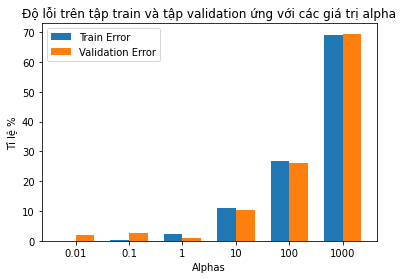

In [32]:
ser1 = pd.Series(train_errs)
ser2 = pd.Series(val_errs)

ind = np.arange(len(ser1))
width = 0.35
fig, ax = plt.subplots()
ax.bar(ind - width/2, ser1, width, label='Train Error')
ax.bar(ind + width/2, ser2, width, label='Validation Error')

ax.set_xlabel('Alphas')
ax.set_ylabel('Tỉ lệ %')
ax.set_title('Độ lỗi trên tập train và tập validation ứng với các giá trị alpha')
ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels(alphas)
ax.legend()

plt.show()

In [33]:
print("Best validation error: " + str(best_val_err.round(2)) + '%')
print("Best alpha: " + str(best_alpha))

Best validation error: 0.93%
Best alpha: 1


Tạo full pipeline vói best alpha vừa tìm được, huấn luyện trên tập train + tập validation

In [34]:
full_pipeline = pipeline.set_params(mlpclassifier__alpha=best_alpha)
full_pipeline.fit(new_X_df, new_y_sr)

Pipeline(steps=[('coldropper', ColDropper()),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(alpha=1, hidden_layer_sizes=20, max_iter=2500,
                               random_state=0, solver='lbfgs'))])

### Độ lỗi trên tập huấn luyện:

In [35]:
(1 - full_pipeline.score(new_X_df, new_y_sr))*100

1.552795031055898

### Độ lỗi trên tập test là:

In [36]:
(1 - full_pipeline.score(test_X_df, test_y_sr))*100

7.4074074074074066

### Nhận xét

Với mô hình huấn luyện này, độ lỗi thu được trên tập test là ổn và có thể chấp nhận được => Mô hình phân lớp khá tốt khi chon siêu tham số alpha 1 cách hợp lí.

## Thử nghiệm với mô hình K-Neighbors Classifier

Tạo pipeline, điền các giá trị thiếu bằng giá trị trung bình.

In [37]:
pipeline2 = make_pipeline(ColDropper(),
                         SimpleImputer(missing_values=np.nan, strategy='mean'),
                         StandardScaler(),
                         KNeighborsClassifier())

In [38]:
# Thử nghiệm với các giá trị và chọn ra các số neighbors tốt nhất
train_errs = []
val_errs = []
neighbors = [1, 3, 5, 10, 20, 30, 50]
best_val_err = float('inf'); best_neighbor = None
for neighbor in neighbors:
    pipeline2.set_params(kneighborsclassifier__n_neighbors = neighbor)
    pipeline2.fit(train_X_df, train_y_sr)
    train_errs.append((1 - pipeline2.score(train_X_df, train_y_sr))*100)
    val_errs.append((1 - pipeline2.score(val_X_df, val_y_sr))*100)
    if val_errs[-1] <= best_val_err:
        best_val_err = val_errs[-1]
        best_neighbor = neighbor
'Finish!'

'Finish!'

Độ lỗi trên tập huấn luyện và tập validation ứng với giá trị neighbors như sau:

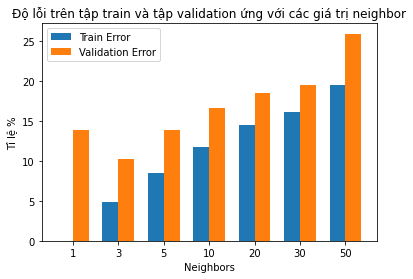

In [39]:
ser1 = pd.Series(train_errs)
ser2 = pd.Series(val_errs)

ind = np.arange(len(ser1))
width = 0.35
fig, ax = plt.subplots()
ax.bar(ind - width/2, ser1, width, label='Train Error')
ax.bar(ind + width/2, ser2, width, label='Validation Error')

ax.set_xlabel('Neighbors')
ax.set_ylabel('Tỉ lệ %')
ax.set_title('Độ lỗi trên tập train và tập validation ứng với các giá trị neighbor')
ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax.set_xticklabels(labels=neighbors)
ax.legend()

plt.show()

In [40]:
print("Best validation error: " + str(best_val_err.round(2)) + '%')
print("Best neighbors: " + str(best_neighbor))

Best validation error: 10.19%
Best neighbors: 3


Tạo full pipeline vói best alpha vừa tìm được, huấn luyện trên tập train + tập validation

In [41]:
full_pipeline2 = pipeline2.set_params(kneighborsclassifier__n_neighbors=best_neighbor)
full_pipeline2.fit(new_X_df, new_y_sr)

Pipeline(steps=[('coldropper', ColDropper()),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))])

Độ lỗi trên tập huấn luyện

In [42]:
(1- pipeline2.score(new_X_df, new_y_sr)) * 100

3.7267080745341574

Độ lỗi trên tập test

In [43]:
(1- pipeline2.score(test_X_df, test_y_sr)) * 100

19.444444444444443

### Nhận xét

Như vậy độ lỗi trên tập test lớn hơn nhiều so với độ lỗi trên tập huấn luyện.

## Thử nghiệm với mô hình Decision Tree Classifier

Tạo pipeline, điền các giá trị thiếu bằng giá trị trung bình.

In [44]:
pipeline3 = make_pipeline(ColDropper(),
                         SimpleImputer(missing_values=np.nan, strategy='mean'),
                         StandardScaler(),
                         DecisionTreeClassifier())

In [45]:
# Fit dữ liệu vào mô hình.
pipeline3.fit(new_X_df, new_y_sr)

Pipeline(steps=[('coldropper', ColDropper()),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

Độ lỗi trên tập huấn luyện và tập validation:

In [46]:
(1 -pipeline3.score(new_X_df, new_y_sr)) * 100

0.0

Độ lỗi trên tập test:

In [47]:
(1 - pipeline3.score(test_X_df, test_y_sr)) * 100

0.92592592592593

### Nhận xét

Vậy, trong trường hợp bài toán này thì Decision Tree thực hiện phân lớp với độ chính xác cao hơn nhiều trên tập test so với thuật  toán MLP.

## Tóm lại

Các thuật toán nhóm đã chọn fit khá tốt với tập dữ liệu đã chọn. Tuy nhiên độ lỗi trên tập test của thuật toán K-Neighbors Classifier là khá cao (gần 20%) nên ta chỉ nên xem xét sử dụng MLPClassifier hay Decision Tree Classifier để đánh giá khi có tập test mới để có được dự đoán kết quả chất lượng không khí tin cậy nhất.

# Nhìn lại quá trình làm đồ án

## Những khó khăn gặp phải trong quá trình làm đồ án

Đầu tiên là khó khăn trong việc lựa chọn chủ đề sao cho dữ liệu về chủ đề đó phong phú và có thể thu thập được.
- Có những trang web lại hạn chế về số lượng request.
- Có những chủ đề mà lượng dữ liệu lại hạn chế, thiếu những thuộc tính cần thu thập,...

Khó khăn trong việc lựa chọn mô hình phân lớp phù hợp với tập dữ liệu.

Hạn chế về matplotlib nên không thể trực quan hóa dữ liệu một cách sinh động.

## Ghi nhận những sự góp ý của các nhóm

### Góp ý của bạn Lê Minh Đức (nhóm 36)

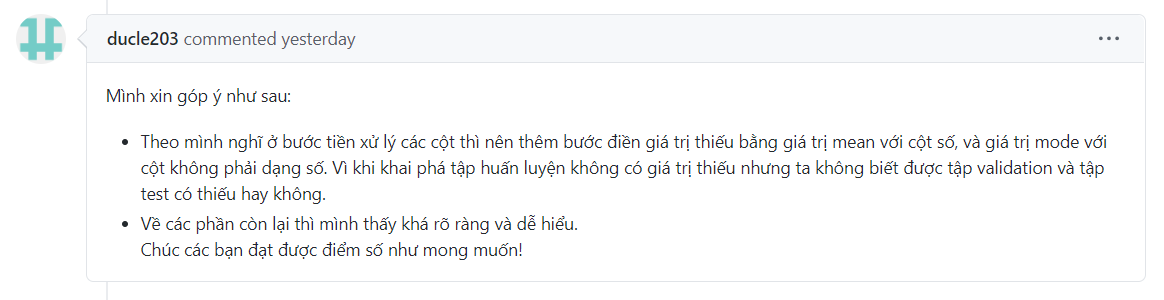

### Góp ý của bạn Hoàng Gia Bảo (nhóm 36)

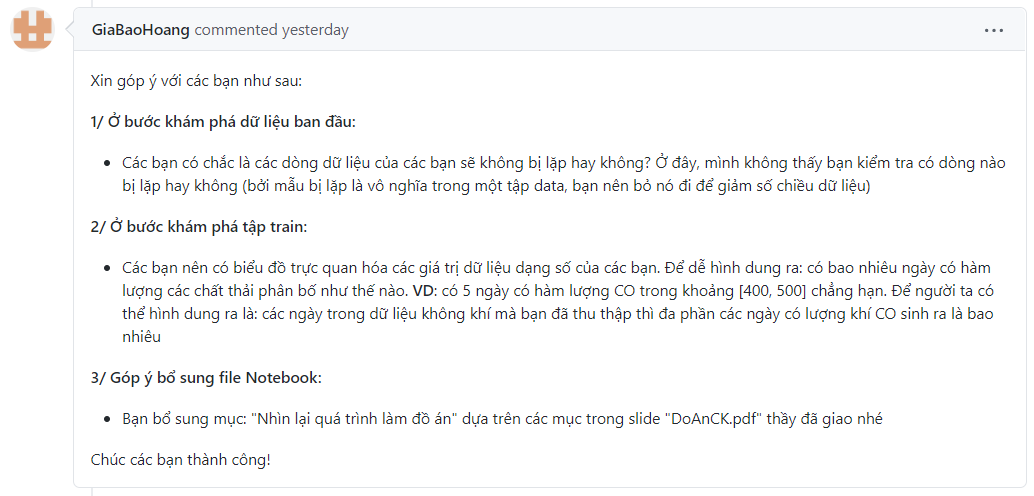

Qua những sự góp ý của nhóm bạn thì nhóm em nhận ra được nhiều thiếu xót và đã chỉnh sửa kịp thời.
- Thêm hàm xử lý các giá trị bị thiếu để đề phòng việc thiếu dữ liệu ở tập test sau này.
- Kiểm tra sự trùng lặp các dòng dữ liệu có sảy ra hay không và có biện pháp xử lý.

## Những điều hữu ích học được

- Có kinh nghiệm hơn trong việc thu thập dữ liệu và tiền xử lý dữ liệu.
- Biết cách mô hình hóa dữ liệu và đánh giá mô hình thu được.
- Biết thêm những thuật toán phân lớp hữu ích.

Nếu có thêm thời gian thì nhóm em sẽ thu thập thêm nhiều loại dữ liệu đa dạng hơn, thử mô hình hóa với nhiều thông số khác nhau của các thuật toán phân lớp để có được mô hình và độ lỗi test tốt nhất.

# Tài liệu tham khảo

https://scikit-learn.org (Tham khảo các thuật toán phân lớp có trong đồ án).

https://openweathermap.org/api (Tham khảo về ý nghĩa của các cột dữ liệu thu được)

Tham khảo cách tiền xử lý, khám phá, mô hình hóa dữ liệu từ Bài tập 03 và các bài tập trước đó.

Slide bài giảng.